In [29]:
import qiskit 
import numpy as np
from qiskit.visualization import plot_histogram

my_gate_names = {
    "displaytext": {
        # gate name : gate text 
        "x": "Pauli X",
        "y": "Pauli Y",
        "z": "Pauli Z",
        "h": "Hadamard",
        "reset": "Reset",
        "id": "Identity",
    },
}

def unitary_operator_c(theta):
    return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(1)

def apply_unitary_operator(quantum_circuit, theta, control, target, exponent):
    #Rechne theta * exponent da schneller als exponent-Fache anwendung von U
    quantum_circuit.append(unitary_operator_c(theta/(2**exponent)),[control, target])

def unitary_operator(theta):
    return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))

#Bsp: n = 3 dann gibs 3 qubits. Bit gibt die position an in [2,1,0] mit 2 = MSB, wenn Bit = 0 dann MSB
def calc_unitary_operator(bit,n,a_bin):
    theta = 0.0
    i = 1
    for x in range(bit,n):
        if a_bin[x] == 1:
            theta = theta + ((2 * np.pi)/(2**i))
        i += 1
    return unitary_operator(theta)    

#Fb position der Qubits im quantum_circuit z.B. [2,1,0] mit dem ersten als MSB
#a_bin a in Binärdarstellung mit [1,0,0] wobei index 0 MSB ist
def quantum_Addition(quantum_circuit,Fb,a_bin):
    i = 0
    for x in range(len(Fb)):
        quantum_circuit.append(calc_unitary_operator(i, len(Fb),a_bin),[Fb[i]])
        i+=1
#b position der Qubits im quantum_circuit z.B. [2,1,0] mit dem ersten als MSB
#a_bin index 0 msb
def apply_quantum_Addition(quantum_circuit,a_bin,b,measure_result = True):
    myQFT(quantum_circuit,b)
    quantum_Addition(quantum_circuit,b,a_bin)
    myQFT(quantum_circuit,b,inverse = True)
    if measure_result:
        quantum_circuit.measure(b,range(len(b)))

def myQFT(quantum_circuit, measurement_qubits, inverse = False, swaps = False):
    if not inverse:
        for target in measurement_qubits:
            quantum_circuit.barrier()
            exponent = 2
            quantum_circuit.h(target)
            for control in measurement_qubits[target + 1:]:
                apply_unitary_operator(quantum_circuit, 2 * np.pi, control, target, exponent)
                exponent+=1
        quantum_circuit.barrier()
        if swaps:
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        quantum_circuit.barrier()
    else:
        if swaps:
            quantum_circuit.barrier()
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        for target in reversed(measurement_qubits):
            quantum_circuit.barrier()
            exponent = len(measurement_qubits[target + 1:]) + 1
            for control in reversed(measurement_qubits[target + 1:]):
                apply_unitary_operator(quantum_circuit, -2 * np.pi, control, target, exponent)
                exponent -= 1
            quantum_circuit.h(target)
        quantum_circuit.barrier()

In [51]:
qc = qiskit.QuantumCircuit(4,4)
qc.initialize([0,1],1)
qc.initialize([0,1],2)
qc.initialize([0,1],3)
apply_quantum_Addition(qc,[0,1,1,1],[0,1,2,3])
qc.draw()

░ ┌───┐                            ░               »
q_0: ────────────────────░─┤ H ├─■────────■────────■────────░───────────────»
     ┌─────────────────┐ ░ └───┘ │P(π/2)  │        │        ░ ┌───┐         »
q_1: ┤ Initialize(0,1) ├─░───────■────────┼────────┼────────░─┤ H ├─■───────»
     ├─────────────────┤ ░                │P(π/4)  │        ░ └───┘ │P(π/2) »
q_2: ┤ Initialize(0,1) ├─░────────────────■────────┼────────░───────■───────»
     ├─────────────────┤ ░                         │P(π/8)  ░               »
q_3: ┤ Initialize(0,1) ├─░─────────────────────────■────────░───────────────»
     └─────────────────┘ ░                                  ░               »
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«               ░                ░       ░  ░ ┌─────────────────────────┐ ░ »
«q_0: ──────────░────────────────░───────░──░─┤ 2.748893571891069(7π/8) ├─░─»
«               ░                ░       ░  ░ ├─────────────────────────┤ ░ »
«q_1: ─■────────░────────────────░───────░──░─┤ 5.497787143782138(7π/4) ├─░─»
«      │        ░ ┌───┐          ░       ░  ░ └┬────────────────────────┤ ░ »
«q_2: ─┼────────░─┤ H ├─■────────░───────░──░──┤ 4.71238898038469(3π/2) ├─░─»
«      │P(π/4)  ░ └───┘ │P(π/2)  ░ ┌───┐ ░  ░  └┬──────────────────────┬┘ ░ »
«q_3: ─■────────░───────■────────░─┤ H ├─░──░───┤ 3.141592653589793(π) ├──░─»
«               ░                ░ └───┘ ░  ░   └──────────────────────┘  ░ »
«c: 4/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«           ░                 ░                           ░           »
«q_0: ──────░─────────────────░───────────────────────────░──■────────»
«           ░                 ░                     ┌───┐ ░  │        »
«q_1: ──────░─────────────────░──■─────────■────────┤ H ├─░──┼────────»
«           ░           ┌───┐ ░  │         │P(-π/2) └───┘ ░  │        »
«q_2: ──────░──■────────┤ H ├─░──┼─────────■──────────────░──┼────────»
«     ┌───┐ ░  │P(-π/2) └───┘ ░  │P(-π/4)                 ░  │P(-π/8) »
«q_3: ┤ H ├─░──■──────────────░──■────────────────────────░──■────────»
«     └───┘ ░                 ░                           ░           »
«c: 4/════════════════════════════════════════════════════════════════»
«                                                                     »
«                         ┌───┐ ░ ┌─┐         
«q_0: ─■─────────■────────┤ H ├─░─┤M├─────────
«      │         │P(-π/2) └───┘ ░ └╥┘┌─┐      
«q_1: ─┼─────────■──────────────░──╫─┤M├──────
«      │P(-π/4)                 ░  ║ └╥┘┌─┐   
«q_2: ─■────────────────────────░──╫──╫─┤M├───
«                               ░  ║  ║ └╥┘┌─┐
«q_3: ──────────────────────────░──╫──╫──╫─┤M├
«                               ░  ║  ║  ║ └╥┘
«c: 4/═════════════════════════════╩══╩══╩══╩═
«                                  0  1  2  3

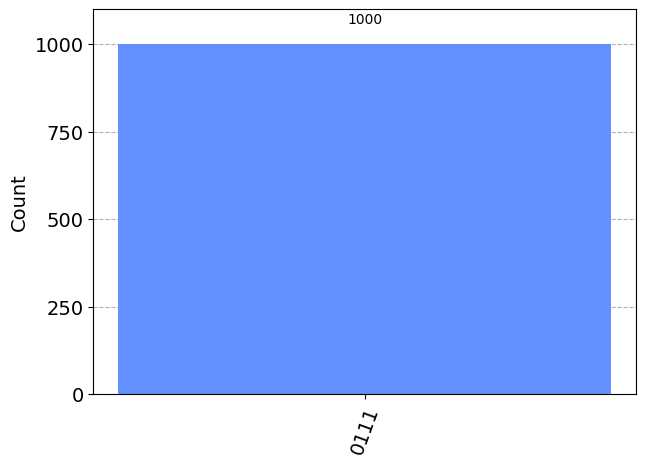

In [52]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)